## Reference: https://github.com/WuJie1010/Facial-Expression-Recognition.Pytorch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd "drive/MyDrive/CSC420-Project-master"

Mounted at /content/drive
/content/drive/MyDrive/CSC420-Project-master


In [12]:
# !python preprocess_fer2013.py

(28709, 2304)
(3589, 2304)
(3589, 2304)
Save data finish!!!


In [28]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os

from torch.autograd import Variable

# import argparse
import utils
# dataclass
from fer import FER2013
# model declarations
from models import *

In [4]:
class Opt():
  def __init__(self):
    self.model = "VGG_ba_small"
    self.dataset = "FER2013"
    self.bs = 128
    self.lr = .01
  
  def __str__(self):
    return f"model = {self.model}\ndataset = {self.dataset}\nbatchsize = {self.bs}\nlearning rate = {self.lr}"

opt = Opt()
print(opt)

model = VGG_ba_small
dataset = FER2013
batchsize = 128
learning rate = 0.01


In [5]:
# params
use_cuda = torch.cuda.is_available()
print("training on CPU" if not use_cuda else "GPU in place!")

best_validation_acc = 0  # best validation accuracy
best_validation_acc_epoch = 0
best_test_acc = 0  # best test accuracy
best_test_acc_epoch = 0

learning_rate_decay_start = 40  # 50
learning_rate_decay_every = 5 # 5
learning_rate_decay_rate = 0.9 # 0.9

cut_size = 44
total_epoch = 250

path = os.path.join(opt.dataset + '_' + opt.model)
print(f"savepath is {path}")

GPU in place!
savepath is FER2013_VGG_ba_small


In [6]:
# # Data
# print('==> Preparing data..')
# transform_train = transforms.Compose([
#     transforms.RandomCrop(cut_size),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
# ])

# transform_test = transforms.Compose([
#     transforms.TenCrop(cut_size),
#     transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
# ])

# trainset = FER2013(split = 'Training', transform=transform_train)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=opt.bs, shuffle=True, num_workers=1)
# validationset = FER2013(split = 'validation', transform=transform_test)
# validationloader = torch.utils.data.DataLoader(validationset, batch_size=opt.bs, shuffle=False, num_workers=1)
# testset = FER2013(split = 'test', transform=transform_test)
# testloader = torch.utils.data.DataLoader(testset, batch_size=opt.bs, shuffle=False, num_workers=1)

==> Preparing data..


In [7]:
# Model

if opt.model  == 'Resnet18':
    net = ResNet18()
elif opt.model == 'Xception':
    net = Xception(input_channel=3)
elif opt.model.startswith('VGG_ba_small'):
    net = VGG(opt.model)

print(f'==> Building model {opt.model}..')

if use_cuda:
    net.cuda()

criterion = nn.CrossEntropyLoss()
# SGD could be more generalizable but it is slower in convergence
# weight decay option adds regularization. 
optimizer = optim.SGD(net.parameters(), lr=opt.lr, momentum=.9, weight_decay=5e-4)
# optimizer = optim.Adam(net.parameters(), lr=opt.lr, weight_decay=5e-4)

==> Building model VGG_ba_small..


In [8]:
# # Training
# def train(epoch):
#     print('\n---\nEpoch: %d' % epoch)
#     net.train()
#     train_loss = 0
#     correct = 0
#     total = 0

#     if epoch > learning_rate_decay_start and learning_rate_decay_start >= 0:
#         frac = (epoch - learning_rate_decay_start) // learning_rate_decay_every
#         decay_factor = learning_rate_decay_rate ** frac
#         current_lr = opt.lr * decay_factor
#         utils.set_lr(optimizer, current_lr)  # set the decayed rate
#     else:
#         current_lr = opt.lr
#     print('learning_rate: %s' % str(current_lr))

#     for batch_idx, (inputs, targets) in enumerate(trainloader):
#         if use_cuda:
#             inputs, targets = inputs.cuda(), targets.cuda()
#         optimizer.zero_grad()
#         inputs, targets = Variable(inputs), Variable(targets)
#         outputs = net(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         utils.clip_gradient(optimizer, 0.1)
#         optimizer.step()
#         train_loss += loss.data
#         _, predicted = torch.max(outputs.data, 1)
#         total += targets.size(0)
#         correct += predicted.eq(targets.data).cpu().sum()

#         # for command line
#         # utils.progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#         #     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

#     Train_acc = 100.*correct/total
#     print(f"Trainning Accuracy: {Train_acc:.10f}")

In [63]:
# def validation(epoch):
#     global validation_acc
#     global best_validation_acc
#     global best_validation_acc_epoch
#     net.eval()
#     validation_loss = 0
#     correct = 0
#     total = 0
#     for batch_idx, (inputs, targets) in enumerate(validationloader):
#         bs, ncrops, c, h, w = np.shape(inputs)
#         inputs = inputs.view(-1, c, h, w)
#         if use_cuda:
#             inputs, targets = inputs.cuda(), targets.cuda()
#         with torch.no_grad():
#           # inputs, targets = Variable(inputs, volatile=True), Variable(targets)
#           outputs = net(inputs)
#           outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops
#           loss = criterion(outputs_avg, targets)
#           validation_loss += loss.data
#           _, predicted = torch.max(outputs_avg.data, 1)
#           total += targets.size(0)
#           correct += predicted.eq(targets.data).cpu().sum()

#           # for command line
#           # utils.progress_bar(batch_idx, len(validationloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#           #                   % (validation_loss / (batch_idx + 1), 100. * correct / total, correct, total))

#     # Save checkpoint.
#     validation_acc = 100.*correct/total
#     print("validation_acc: %0.3f" % validation_acc)
#     if validation_acc > best_validation_acc:
#         print('Saving..')
#         print("best_validation_acc: %0.3f" % validation_acc)
        
#         state = {
#             'net': net.state_dict() if use_cuda else net,
#             'acc': validation_acc,
#             'epoch': epoch,
#         }
#         if not os.path.isdir(path):
#             os.mkdir(path)
#         torch.save(state, os.path.join(path,'validation_model.t7'))
#         best_validation_acc = validation_acc
#         best_validation_acc_epoch = epoch

In [10]:
# # deprecated, we will be keeping test set only for the best validation model
# def test(epoch):
#     global test_acc
#     global best_test_acc
#     global best_test_acc_epoch
#     net.eval()
#     test_loss = 0
#     correct = 0
#     total = 0
#     for batch_idx, (inputs, targets) in enumerate(testloader):
#         bs, ncrops, c, h, w = np.shape(inputs)
#         inputs = inputs.view(-1, c, h, w)
#         if use_cuda:
#             inputs, targets = inputs.cuda(), targets.cuda()
#         with torch.no_grad():
#           # inputs, targets = Variable(inputs, volatile=True), Variable(targets)
#           outputs = net(inputs)
#           outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops
#           loss = criterion(outputs_avg, targets)
#           test_loss += loss.data
#           _, predicted = torch.max(outputs_avg.data, 1)
#           total += targets.size(0)
#           correct += predicted.eq(targets.data).cpu().sum()

#           utils.progress_bar(batch_idx, len(validationloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#               % (test_loss / (batch_idx + 1), 100. * correct / total, correct, total))
#     # Save checkpoint.
#     test_acc = 100.*correct/total

#     if test_acc > best_test_acc:
#         print('Saving..')
#         print("best_test_acc: %0.3f" % max(test_acc, best_test_acc))
#         state = {
#             'net': net.state_dict() if use_cuda else net,
#             'best_validation_acc': best_validation_acc,
#             'best_test_acc': test_acc,
#             'best_validation_acc_epoch': best_validation_acc_epoch,
#             'best_test_acc_epoch': epoch,
#         }
#         if not os.path.isdir(path):
#             os.mkdir(path)
#         torch.save(state, os.path.join(path,'test_model.t7'))
#         best_test_acc = test_acc
#         best_test_acc_epoch = epoch

In [60]:
# print(opt)

# # training loop
# for epoch in range(total_epoch):
#     train(epoch)
#     validation(epoch)
#     # test(epoch)

# print("best_validation_acc: %0.3f" % best_validation_acc)
# print("best_validation_acc_epoch: %d" % best_validation_acc_epoch)
# # print("best_test_acc: %0.3f" % best_test_acc)
# # print("best_test_acc_epoch: %d" % best_test_acc_epoch)

model = VGG_ba_small
dataset = FER2013
batchsize = 128
learning rate = 0.01

---
Epoch: 0
learning_rate: 0.01
Trainning Accuracy: 91.1421508789
validation_acc: 63.416
Saving..
best_validation_acc: 63.416

---
Epoch: 1
learning_rate: 0.01
Trainning Accuracy: 87.7042007446
validation_acc: 65.143
Saving..
best_validation_acc: 65.143

---
Epoch: 2
learning_rate: 0.01
Trainning Accuracy: 88.3346710205
validation_acc: 64.113

---
Epoch: 3
learning_rate: 0.01
Trainning Accuracy: 89.4458160400
validation_acc: 64.029

---
Epoch: 4
learning_rate: 0.01
Trainning Accuracy: 90.1076354980
validation_acc: 64.726

---
Epoch: 5
learning_rate: 0.01
Trainning Accuracy: 90.7555084229
validation_acc: 66.620
Saving..
best_validation_acc: 66.620

---
Epoch: 6
learning_rate: 0.01
Trainning Accuracy: 90.8704605103
validation_acc: 66.397

---
Epoch: 7
learning_rate: 0.01
Trainning Accuracy: 91.0167541504
validation_acc: 67.010
Saving..
best_validation_acc: 67.010

---
Epoch: 8
learning_rate: 0.01
Trainning Accu

KeyboardInterrupt: ignored

In [21]:
net.load_state_dict(torch.load(os.path.join(path,'validation_model.t7'))['net'])

<All keys matched successfully>

In [50]:
preprocess2 = transforms.Compose([
    transforms.Resize(44),
    transforms.CenterCrop(44),
    transforms.ToTensor()
])
# load from whereever Qinchen's photos are stored
my_face = torchvision.datasets.ImageFolder(root='../csc420_project/test_data/', transform=preprocess2)

In [51]:
myfaceloader = torch.utils.data.DataLoader(my_face, batch_size=1,
                                         shuffle=False, num_workers=2)

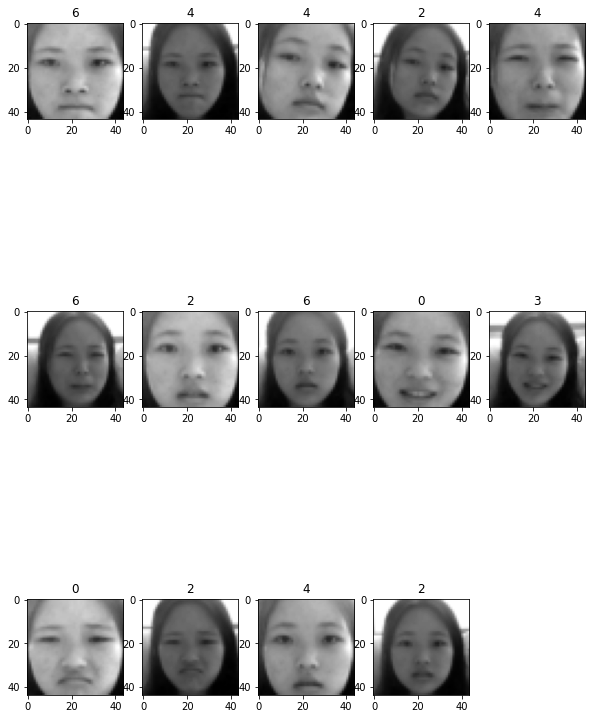

In [64]:
plt.figure(figsize=(10, 15))
device = torch.device("cuda")

for i, data in enumerate(myfaceloader, 0):
  inputs, _ = data
  inputs[0][1] = inputs[0][0]
  inputs[0][2] = inputs[0][0]
  outputs = net(inputs.cuda())
  plt.subplot(3, 5, i+1)
  plt.imshow(inputs[0][0], cmap='gray')
  plt.title(outputs.argmax(axis=1).item())

plt.show()
  